In [55]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

In [56]:
def gen_sample(batch_size, N_agents, in_dim = None, L = None):
    """ 
        generates an inital states in [0,L1] x [0,L2] x ... x [0, Ln] of shape [Batch_size, in_dim]
    """
    if in_dim is None and L is None:
        raise ValueError("Need either L or in dim to be set")
    if in_dim is None:
        in_dim = len(L)
    if L is None:
        L = [1. for _ in range(in_dim)]
    x = torch.rand(batch_size, N_agents, in_dim).abs()
    for i in range(len(L)):
        x[:, :, i] = torch.clamp(x[:, :, i], max=L[i])
    return x


In [57]:
N_Agents = 1
in_dim = 1
batch_size = 256
n_samples = 512
timesteps = 30
lam = 0.5
k_max = 8
control_energy_reg = 1e-6 ### regularization on maximum control energy
u_max = 100 # does not do anything currently
thres = 0#1e-2 ### softness on constraint (will penalize when this much outside of rect)


In [58]:
densties = ['custom']
regions = [
        torch.tensor([[.0, .3]]),
        torch.tensor([[.6, .9]])
        ]
weights = [.5, .5]

In [59]:
def custom_pdf(x):
    """
     Define a custom probability density function (PDF).
    """
    #x = x.item()
    #return np.where(((x > 0) & (x < 1)), 1, 0)
    return np.where(((x > 0) & (x < 0.3)) | ((x > 0.6) & (x < 0.9)), 5 / 3, 0)

In [60]:
import Ergodic_Loss
import Recursive_KAN
import sys
sys.path.append(r'C:\Users\JP\Documents\TU Berlin\Master\Code_RNN\Recursive_kan\Ergodic_Loss.py') 
sys.path.append(r'C:\Users\JP\Documents\TU Berlin\Master\Code_RNN\Recursive_kan\Recursive_KAN.py') 
import importlib
importlib.reload(Ergodic_Loss)
importlib.reload(Recursive_KAN)
criterion = Ergodic_Loss.Ergodicity_Loss(N_Agents = N_Agents, n_timesteps = timesteps,L = None, in_dim = in_dim, k_max = k_max, thres = thres, control_energy_reg = control_energy_reg, density = 'custom',verbose = False, pdf = custom_pdf, max_pdf = 5/3, num_samples = 100000)
model = Recursive_KAN.KAN_RNN_Layer(N_Agents = N_Agents, in_dim = in_dim, hidden = 128, depth = 2, n_timesteps = timesteps,sys_param_lam= lam, u_max = u_max, network_type='multi')
model.init_hidden(batch_size = batch_size)

tensor([ 1.0000,  0.1259,  0.3559,  0.4256, -0.4682,  0.0018, -0.0707,  0.0587]) target distribution


per iter: 0.5858402252197266 total time: 585.8402252197266
Epoch [1/500], Loss: 0.012754
Epoch [2/500], Loss: 0.007195
Epoch [3/500], Loss: 0.004624
Epoch [4/500], Loss: 0.009847
Epoch [5/500], Loss: 0.013095
Epoch [6/500], Loss: 0.012072
Epoch [7/500], Loss: 0.008718
Epoch [8/500], Loss: 0.004790
Epoch [9/500], Loss: 0.002262
Epoch [10/500], Loss: 0.001537
Epoch [11/500], Loss: 0.000652
Epoch [12/500], Loss: 0.000305
Epoch [13/500], Loss: 0.000505
Epoch [14/500], Loss: 0.001012
Epoch [15/500], Loss: 0.001129
Epoch [16/500], Loss: 0.000523
Epoch [17/500], Loss: 0.000243
Epoch [18/500], Loss: 0.000149
Epoch [19/500], Loss: 0.000177
Epoch [20/500], Loss: 0.000269
Epoch [21/500], Loss: 0.000317
Epoch [22/500], Loss: 0.000323
Epoch [23/500], Loss: 0.000285
Epoch [24/500], Loss: 0.000221
Epoch [25/500], Loss: 0.000177
Epoch [26/500], Loss: 0.000153
Epoch [27/500], Loss: 0.000153
Epoch [28/500], Loss: 0.000155
Epoch [29/500], Loss: 0.000173
Epoch [30/500], Loss: 0.000170
Epoch [31/500], Loss

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Epoch [500/500], Loss: 0.000056


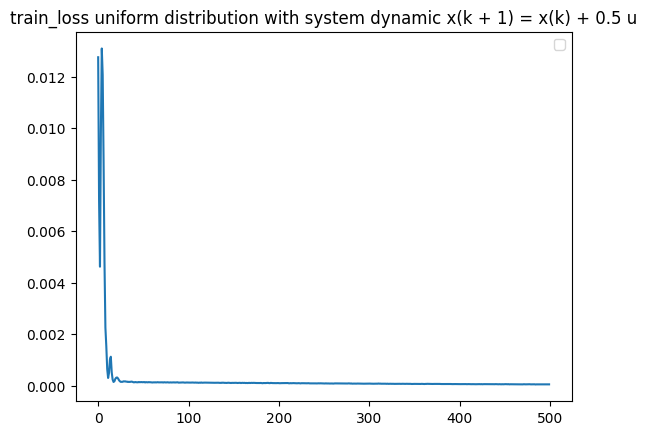

Training Complete!


In [70]:
import time
criterion.verbose = False
epochs = 500  # Number of epochs to train
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)
train_loss = []
test_loss = []
model.train()  # Set the model to training mode
show = True
for epoch in range(epochs):
    running_loss = 0.0 
    for samples in range(n_samples // batch_size):
        start_time = time.time()
        model.init_hidden(batch_size = batch_size)
        optimizer.zero_grad()
        control , outputs = model(gen_sample(batch_size = batch_size, N_agents = N_Agents, in_dim = in_dim))
        loss = criterion(x = outputs, u = control) + model.penalty #* 1e-2 ## punishment on leaving the rect
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if show:
            show = False
            criterion.verbose = False
            print("per iter:", time.time()- start_time,"total time:" , (time.time()- start_time) * (n_samples / batch_size) * epochs)
    avg_loss = running_loss / (n_samples)# // batch_size)
    train_loss.append(avg_loss)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.6f}")
plt.plot(train_loss)
plt.title(f'train_loss uniform distribution with system dynamic x(k + 1) = x(k) + {lam} u')
plt.legend()
plt.show()
print("Training Complete!")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


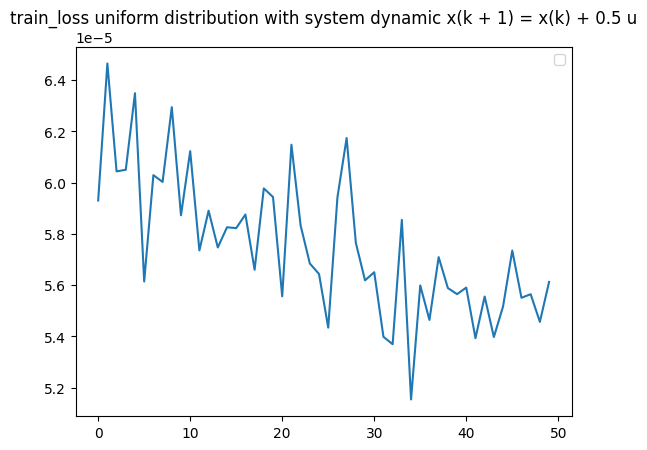

Training Complete!


In [75]:
#scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
#    optimizer, 
#    T_0=10,          # Number of iterations for the first restart
#    T_mult=2,        # Factor by which T_0 is multiplied after each restart
#    eta_min=0        # Minimum learning rate after annealing
#)

plt.plot(train_loss[-50:])
plt.title(f'train_loss uniform distribution with system dynamic x(k + 1) = x(k) + {lam} u')
plt.legend()
plt.show()
print("Training Complete!")

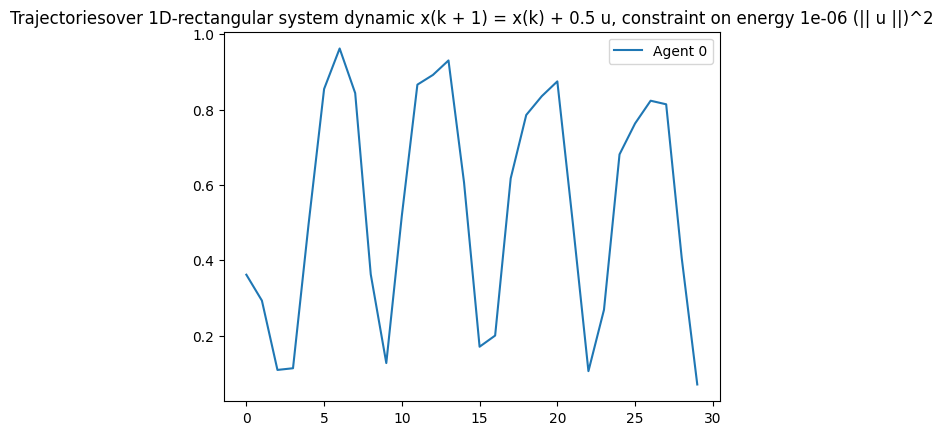

In [76]:
#plot trajectory
model.eval()
inital_state = gen_sample(batch_size = 1, N_agents = N_Agents, in_dim = in_dim)
model.init_hidden(batch_size = 1)
outs, control = model(inital_state)
for j in range(N_Agents):
    plt.plot(outs[:,:,j,:].squeeze().detach(), label = f'Agent {j}')
plt.title(f'Trajectoriesover 1D-rectangular system dynamic x(k + 1) = x(k) + {lam} u, constraint on energy {control_energy_reg} (|| u ||)^2')
plt.legend()
plt.show()



In [77]:
import Ergodic_Loss
import sys
sys.path.append(r'C:\Users\JP\Documents\TU Berlin\Master\Code_RNN\Recursive_kan\Ergodic_Loss.py') 
import importlib
importlib.reload(Ergodic_Loss)
criterion = Ergodic_Loss.Ergodicity_Loss(N_Agents = N_Agents, n_timesteps = timesteps,L = None, in_dim = in_dim, k_max = k_max,control_energy_reg = control_energy_reg, density = 'custom', pdf = custom_pdf, max_pdf = 5 / 3, num_samples = 100000)
inital_state = gen_sample(batch_size = 1, N_agents = N_Agents, in_dim = in_dim)
model.init_hidden(batch_size = 1)
outs, control = model(inital_state)
criterion.verbose = True
criterion(x = outs, u = control)

tensor([ 1.0000,  0.1294,  0.3568,  0.4243, -0.4681, -0.0029, -0.0732,  0.0567]) target distribution
model tensor([[ 1.0000e+02, -2.7915e+00,  3.0404e-01,  4.2393e-02, -2.0277e-01,
          8.5167e-02, -5.5354e-02,  6.9158e-03]], grad_fn=<MulBackward0>) target tensor([ 1.0000e+02,  1.1905e+00,  8.8149e-01,  4.7232e-01, -2.9453e-01,
        -1.1710e-03, -2.0556e-02,  1.1700e-02])
scaling tensor([100.0000,   9.2000,   2.4705,   1.1133,   0.6293,   0.4036,   0.2807,
          0.2064])


tensor(2.0490, grad_fn=<AddBackward0>)

In [69]:
criterion(x = outs, u = control)

model tensor([[ 1.0000e+02, -2.1720e+00,  1.0679e+00, -1.6012e-01,  1.0620e-01,
          5.3329e-02, -4.1456e-02,  5.4750e-02]], grad_fn=<MulBackward0>) target tensor([ 1.0000e+02,  1.1579e+00,  8.8681e-01,  4.7912e-01, -2.9114e-01,
         9.4920e-04, -2.0703e-02,  1.1552e-02])
scaling tensor([100.0000,   9.2000,   2.4705,   1.1133,   0.6293,   0.4036,   0.2807,
          0.2064])


tensor(1.4615, grad_fn=<AddBackward0>)